In [116]:
import pandas as pd
import numpy as np
import math
# import scipy as sp
import matplotlib.pyplot as plt
from time import sleep as fallasleep
from source.local_package import *

In [ ]:

import krakenex
from pykrakenapi import KrakenAPI

In [75]:
color_box = ['blue','red','purple','black']

In [76]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC"]
gapmin= 1440
coins = [coin+"CAD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [66]:
df[coin].head(2)

,time,open,high,low,close,vwap,volume,count
dtime,,,,,,,,
2019-11-20,1574208000,10760.0,10933.0,10664.4,10758.0,10764.7,45.224270,454
2019-11-21,1574294400,10768.0,10792.7,9807.0,10144.6,10283.9,97.805863,802


In [87]:
ax_twin.get_legend_handles_labels()

([<matplotlib.collections.PolyCollection at 0x7febdfb0f280>], ['volume'])

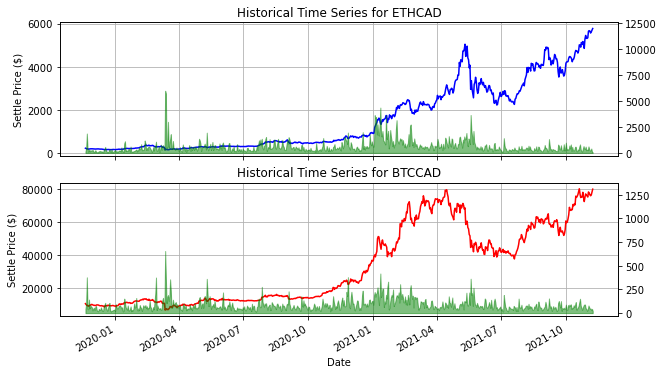

In [111]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(2,1,figsize=(10,6))
for _,coin in enumerate(coins):
    ax[_].plot(df[coin].index, df[coin]['close'].values,
               color=colormapper[coin], label='settle price')
    ax[_].set_title(f"Historical Time Series for {coin}")
    ax[_].set_ylabel("Settle Price ($)")
    ax[_].set_xlabel("Date")
    ax_twin = ax[_].twinx()
    ax_twin.fill_between(df[coin].index, 0, df[coin]['volume'].values,
                         color='green', alpha=0.5, label='volume')
    ax_ylim = ax_twin.get_ylim()
    ax_twin.set_ylim(ax_ylim[0], ax_ylim[1]*2)
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

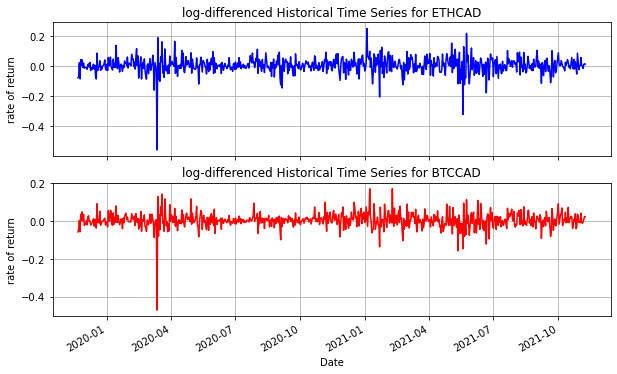

In [138]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(2,1,figsize=(10,6))
df_diff = {}
for coin in coins:
    df_diff[coin] = df[coin].apply(np.log).diff().dropna()
for _,coin in enumerate(coins):
    ax[_].plot(df_diff[coin].index, df_diff[coin]['close'].values,
               color=colormapper[coin], label='settle price')
    ax[_].set_title(f"log-differenced Historical Time Series for {coin}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

In [151]:
df_diff_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_diff_close[coin] = df_diff[coin]['close']

In [155]:
df_diff_close.head(3)

,ETHCAD,BTCCAD
dtime,,
2019-11-21,-0.078129,-0.058708
2019-11-22,-0.074104,-0.044517
2019-11-23,0.021212,0.001895


In [156]:
n_obs = math.floor(len(df[coin])*0.3)
df_train, df_test = df_diff_close[0:-n_obs], df_diff_close[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
for coin in coins:
    print(f'ADF Test: {coin} time series')
    adf_test(df_train[coin])

ADF Test: ETHCAD time series
ADF Statistics: -6.472626
p-value: 0.000000
Critical values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
ADF Test: BTCCAD time series
ADF Statistics: -15.653114
p-value: 0.000000
Critical values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [159]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train, variables = df_train.columns)


,ETHCAD_x,BTCCAD_x
ETHCAD_y,1.0000,0.3206
BTCCAD_y,0.0002,1.0000
